# Load simulated data

In [1]:
import numpy as np
import torch

In [8]:
from sbi.utils import BoxUniform

lower_bound = torch.as_tensor([1.0, 1.0])
upper_bound = torch.as_tensor([5.0, 10.0])
prior = BoxUniform(low=lower_bound, high=upper_bound)

In [4]:
from teddy.data.Alphabet import Alphabet
from teddy.data.dataset import MsaLabels

alphabet = Alphabet(["A", "C", "G", "T"])
simulations = MsaLabels("data/seq", alphabet)

param_labels = ["Basic reproduction number", "Infectious time"]
theta, x = [], []

theta_0 = torch.Tensor(simulations[0][1])
x_0 = torch.flatten(torch.Tensor(simulations[0][0][0]))

for index, simulation in enumerate(simulations):
    if index == 0:
        continue
    theta.append(simulation[1])
    x.append(simulation[0][0])

theta = torch.Tensor(np.array(theta))
x = torch.flatten(torch.Tensor(np.array(x)), start_dim=1)

# NPE training

In [9]:
from sbi.inference import NPE

npe = NPE(prior=prior)
npe.append_simulations(theta, x)
npe.train()

posterior = npe.build_posterior()
samples = posterior.sample((10_000,), x=x_0)

 Neural network successfully converged after 28 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_66919/1409298916.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


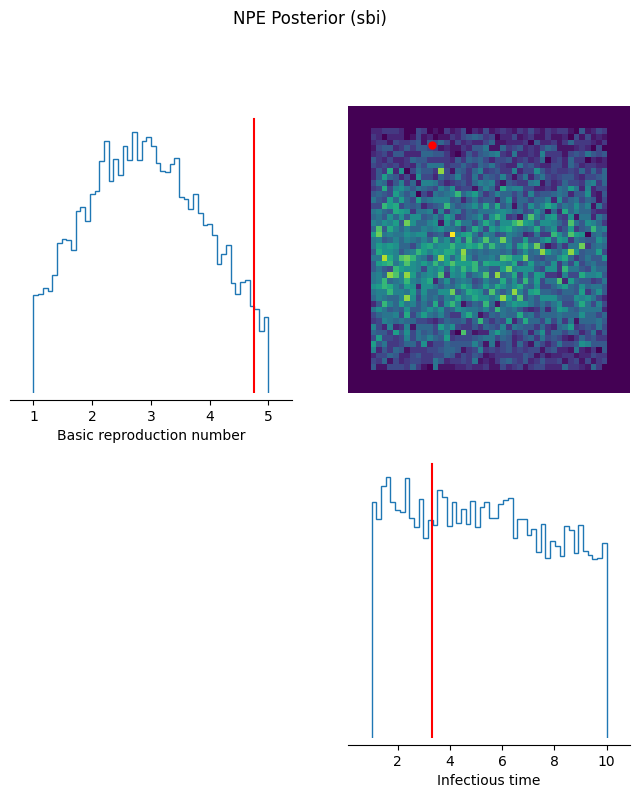

In [10]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

fig, axes = pairplot(
    samples,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()

In [11]:
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding

embedding_net = FCEmbedding(
    input_dim=x.shape[1],
    output_dim=10,
    num_layers=2,
    num_hiddens=50
)
density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)

embedding_npe = NPE(prior=prior, density_estimator=density_estimator)
embedding_npe.append_simulations(theta, x)
embedding_npe.train()

embedding_posterior = embedding_npe.build_posterior()
embedding_samples = embedding_posterior.sample((10_000,), x=x_0)

 Neural network successfully converged after 27 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_66919/3493031812.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


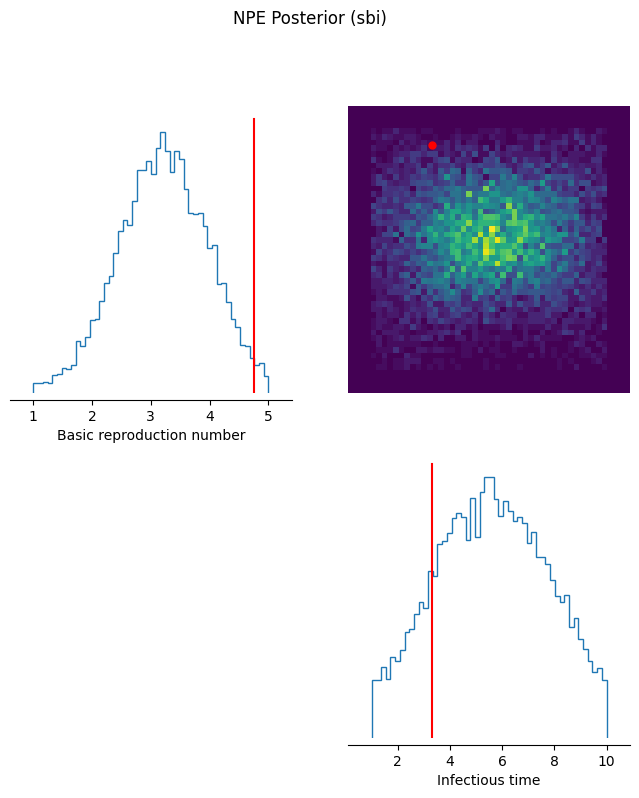

In [12]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

fig, axes = pairplot(
    embedding_samples,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()

/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_66919/926202791.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


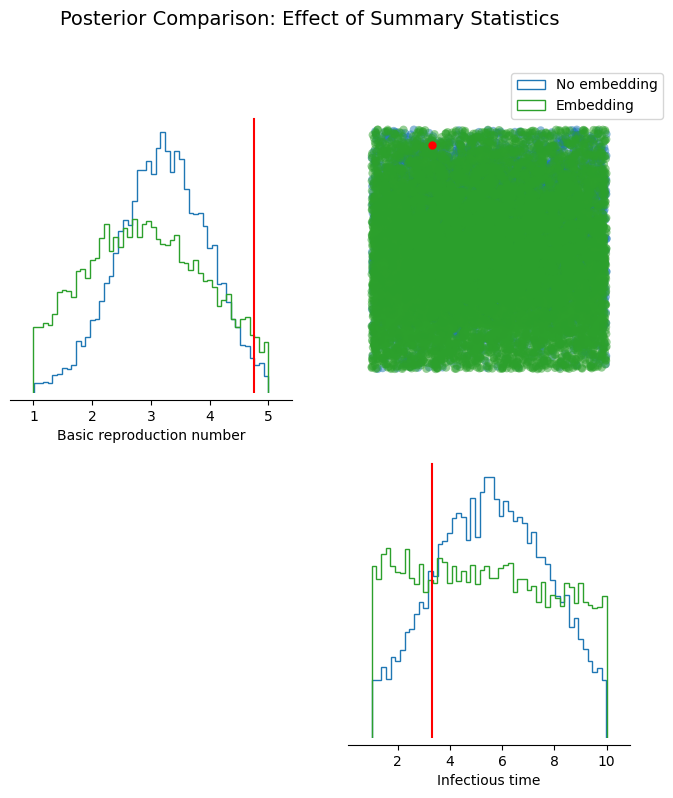

In [13]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

fig, axes = pairplot(
    [embedding_samples, samples],
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,
    points_colors="r",
    diag="hist",
    upper="scatter",
)

# Add legend manually
fig.legend(
    ["No embedding", "Embedding"],
    loc="upper right",
    bbox_to_anchor=(0.95, 0.95),
)
plt.suptitle("Posterior Comparison: Effect of Summary Statistics", y=1.02, fontsize=14)
plt.show()